In [ ]:
!pip install -qq ultralytics
!pip install -qq torchmetrics
!pip install -qq lpips

In [ ]:
import kagglehub
import torch
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
print("Path to dataset files:", path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
#dowload heatmaps
!curl -L -o heatmaps.h5 https://huggingface.co/datasets/RiccardoCarraro/heatmaps/resolve/main/heatmaps_10k.h5

#uncomment the following line to use the 50k version of the dataset
#!curl -L -o heatmaps.h5 https://huggingface.co/datasets/RiccardoCarraro/heatmaps/resolve/main/heatmaps.h5

In [3]:
import h5py
import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from os.path import join, splitext
from PIL import Image
import csv
import numpy as np

class CelebDataSet(Dataset):
    """
    CelebA dataset with optional landmark-heatmap loading from HDF5.

    Returns: (x2, x4, hr, lr, heatmap)
      - x2: 32×32 target tensor
      - x4: 64×64 target tensor
      - hr: 128×128 target tensor
      - lr: 16×16 input tensor
      - heatmap: 1×128×128 float tensor
    """
    def __init__(
        self,
        data_path: str = './dataset/',
        state: str = 'train',
        data_augmentation: bool = False,
        heatmap_h5: str = None,
    ):
        self.main_path = data_path
        self.state = state
        self.data_augmentation = data_augmentation
        self.img_path = join(self.main_path, 'img_align_celeba/img_align_celeba/')
        self.eval_partition_path = join(self.main_path, 'list_eval_partition.csv')

        # load train/val/test split
        train_list, val_list, test_list = [], [], []
        with open(self.eval_partition_path, 'r') as f:
            reader = csv.reader(f)
            for fname, split in reader:
                fname, split = fname.strip(), split.strip()
                if split == '0':
                    train_list.append(fname)
                elif split == '1':
                    val_list.append(fname)
                else:
                    test_list.append(fname)

        if state == 'train':
            self.image_list = sorted(train_list)
        elif state == 'val':
            self.image_list = sorted(val_list)
        else:
            self.image_list = sorted(test_list)

        # transforms
        if state=='train' and data_augmentation:
            self.pre_process = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.CenterCrop((178,178)),
                transforms.Resize((128,128)),
                transforms.RandomRotation(
                    20,
                    interpolation=InterpolationMode.BILINEAR
                ),
                transforms.ColorJitter(0.4,0.4,0.4,0.1)
            ])
        else:
            self.pre_process = transforms.Compose([
                transforms.CenterCrop((178,178)),
                transforms.Resize((128,128)),
            ])

        self.totensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
        ])
        self.down64 = transforms.Resize((64,64))
        self.down32 = transforms.Resize((32,32))
        self.down16 = transforms.Resize((16,16))

        # ACTUALLY load heatmaps into memory
        if heatmap_h5:
            with h5py.File(heatmap_h5, 'r') as h5_file:
                # Load the entire heatmap dataset into RAM
                self.heatmaps = np.array(h5_file['heatmaps'])  # Shape: (N, 128, 128)
        else:
            self.heatmaps = None

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        # load image
        fname = self.image_list[index]
        img = Image.open(join(self.img_path, fname)).convert('RGB')
        img = self.pre_process(img)

        # build multi-scale
        x4 = self.down64(img)    # 64x64
        x2 = self.down32(x4)     # 32x32
        lr = self.down16(x2)     # 16x16

        # to tensor
        hr_tensor = self.totensor(img)
        x4_tensor = self.totensor(x4)
        x2_tensor = self.totensor(x2)
        lr_tensor = self.totensor(lr)

        # load heatmap (already 128×128) - NOW FROM MEMORY!
        if self.heatmaps is not None:
            hm = self.heatmaps[index]              # numpy array (128,128) FROM MEMORY
            heat = torch.from_numpy(hm.copy()).unsqueeze(0)  # (1,128,128)
        else:
            heat = torch.zeros(1,128,128)

        return x2_tensor, x4_tensor, hr_tensor, lr_tensor, heat

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """Efficient DoubleConv with LeakyReLU activation."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UpBlock(nn.Module):
    """Upsampling followed by DoubleConv, with skip connection."""
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_ch + skip_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

class UpLearn(nn.Module):
    """Simpler learned upsampling block."""
    def __init__(self, ch):
        super().__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(ch, ch, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.up(x)

class SuperResolutionUNet(nn.Module):
    """Efficient U-Net super-resolution (16x16 → 128x128)."""
    def __init__(self, in_channels=3, base_filters=32, out_channels=3):
        super().__init__()
        # Encoder (depth reduced)
        self.enc1 = DoubleConv(in_channels, base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck (lighter)
        self.bottleneck = DoubleConv(base_filters*4, base_filters*8)

        # Decoder
        self.up3 = UpBlock(base_filters*8, base_filters*4, base_filters*4)
        self.up2 = UpBlock(base_filters*4, base_filters*2, base_filters*2)
        self.up1 = UpBlock(base_filters*2, base_filters, base_filters)

        # Learned upsampling (simplified, 16→32→64→128)
        self.up_learn1 = UpLearn(base_filters)
        self.up_learn2 = UpLearn(base_filters)
        self.up_learn3 = UpLearn(base_filters)

        # Final projection
        self.final_conv = nn.Conv2d(base_filters, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool1(e1)
        e2 = self.enc2(p1); p2 = self.pool2(e2)
        e3 = self.enc3(p2); p3 = self.pool3(e3)

        b = self.bottleneck(p3)

        d3 = self.up3(b, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)

        u1 = self.up_learn1(d1)  # 32x32
        u2 = self.up_learn2(u1)  # 64x64
        u3 = self.up_learn3(u2)  # 128x128

        out = self.final_conv(u3)
        up_input = F.interpolate(x, size=out.shape[2:], mode='bilinear', align_corners=True)
        return out + up_input

In [ ]:
# Cell 2: loss definitions
import h5py

# pixel
pixel_crit = nn.MSELoss()

# perceptual
from torchvision.models import vgg16
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg16
import lpips

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(pretrained=True).features.eval()
        # qui è cruciale iterare sui parametri, non sui moduli
        for p in vgg.parameters():
            p.requires_grad = False

        # estraiamo i tre slice
        self.slice1 = nn.Sequential(*vgg[:4])   # fino a conv1_2
        self.slice2 = nn.Sequential(*vgg[4:9])  # fino a conv2_2
        self.slice3 = nn.Sequential(*vgg[9:16]) # fino a conv3_3

        # buffers per la normalizzazione
        self.register_buffer('mean', torch.tensor([0.485,0.456,0.406]).view(1,3,1,1))
        self.register_buffer('std',  torch.tensor([0.229,0.224,0.225]).view(1,3,1,1))

    def normalize(self, x):
        # da [-1,1] a [0,1] poi standard VGG
        x = (x + 1) / 2
        return (x - self.mean) / self.std

    def forward(self, sr, hr):
        sr_n, hr_n = self.normalize(sr), self.normalize(hr)
        f1_sr, f1_hr = self.slice1(sr_n), self.slice1(hr_n)
        f2_sr, f2_hr = self.slice2(f1_sr), self.slice2(f1_hr)
        f3_sr, f3_hr = self.slice3(f2_sr), self.slice3(f2_hr)
        return (
            F.mse_loss(f1_sr, f1_hr)
          + F.mse_loss(f2_sr, f2_hr)
          + F.mse_loss(f3_sr, f3_hr)
        )


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
perceptual_crit = VGGPerceptualLoss().to(device)

# attention
def attention_loss(sr, hr, heat, eps=1e-6):
    hmin = heat.flatten(1).min(1)[0].view(-1,1,1,1)
    hmax = heat.flatten(1).max(1)[0].view(-1,1,1,1)
    hn = (heat - hmin)/(hmax-hmin+eps)
    return (hn.expand_as(sr)*(sr-hr).abs()).mean()


# Inizializza il modulo LPIPS (puoi scegliere 'alex', 'vgg', oppure 'squeeze')
# restituisce valori in [0, ∞), più basso = immagini più simili
lpips_crit = lpips.LPIPS(net='alex').to(device)

def lpips_loss(sr, hr):
    """
    sr, hr: tensori in range [-1,1], shape (B,3,H,W)
    Restituisce la distanza LPIPS media sul batch.
    """
    # lpips_crit(sr, hr) ha shape (B,1,1,1)
    return lpips_crit(sr, hr).mean()


In [19]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
import os
import torchvision.transforms as transforms
from torchmetrics.functional import structural_similarity_index_measure as ssim
import numpy as np

class Trainer:
    def __init__(self, cfg):
        self.cfg = cfg
        self.G   = SuperResolutionUNet().to(device)
        self.optG = torch.optim.Adam(self.G.parameters(), lr=cfg['lr_g'])
        self.scaler = torch.amp.GradScaler(device)

    def compute_heatmap_focused_metrics(self, sr, hr, heat):
        """
        Compute metrics that specifically measure how well the model
        performs in regions highlighted by heatmaps.
        """
        with torch.no_grad():
            batch_size = sr.shape[0]
            metrics = {
                'psnr_overall': 0.0,
                'ssim_overall': 0.0,
                'psnr_focused': 0.0,  # PSNR in high-attention regions
                'ssim_focused': 0.0,  # SSIM in high-attention regions
                'mse_focused': 0.0,   # MSE in high-attention regions
                'lpips_overall': 0.0,
                'lpips_focused': 0.0
            }

            for i in range(batch_size):
                sr_i = sr[i:i+1]
                hr_i = hr[i:i+1]
                heat_i = heat[i] if heat is not None else None

                # Overall metrics
                mse_overall = F.mse_loss(sr_i, hr_i)
                psnr_overall = 10 * torch.log10(1.0 / (mse_overall + 1e-8))
                ssim_overall = ssim(sr_i, hr_i, data_range=1.0)
                metrics['lpips_overall'] += lpips_loss(sr_i, hr_i).item()

                metrics['psnr_overall'] += psnr_overall.item()
                metrics['ssim_overall'] += ssim_overall.item()

                # Focused metrics (only if heatmaps available)
                if heat_i is not None:
                    heat_i = heat_i.float()
                    # Create binary mask for top 30% of heatmap values
                    heat_flat = heat_i.flatten()
                    threshold = torch.quantile(heat_flat, 0.7)  # Top 30%
                    focus_mask = (heat_i >= threshold).float()

                    # Expand mask to match image channels
                    focus_mask_3ch = focus_mask.expand_as(sr_i)

                    # Compute metrics only in focused regions
                    sr_focused = sr_i * focus_mask_3ch
                    hr_focused = hr_i * focus_mask_3ch

                    # MSE in focused regions
                    mse_focused = F.mse_loss(sr_focused, hr_focused)
                    psnr_focused = 10 * torch.log10(1.0 / (mse_focused + 1e-8))
                    lpips_focused = lpips_loss(sr_focused, hr_focused)

                    # For SSIM, we need to be careful with masked regions
                    # Use a smaller window and only compute where mask is active
                    focus_area = focus_mask.sum()
                    if focus_area > 100:  # Only if we have enough pixels
                        ssim_focused = ssim(sr_focused, hr_focused, data_range=1.0)
                        metrics['ssim_focused'] += ssim_focused.item()

                    metrics['psnr_focused'] += psnr_focused.item()
                    metrics['mse_focused'] += mse_focused.item()
                    metrics['lpips_focused'] += lpips_focused.item()

            # Average over batch
            for key in metrics:
                metrics[key] /= batch_size

            return metrics

    def train_epoch(self, loader):
        agg = {
            # Loss components (separate for analysis)
            'loss_pixel': 0, 'loss_perc': 0, 'loss_attn': 0, 'loss_lpips': 0, 'loss_combined': 0,
            # Overall quality metrics
            'psnr_overall': 0, 'ssim_overall': 0, 'lpips_overall': 0,
            # Heatmap-focused metrics (the key ones for your research!)
            'psnr_focused': 0, 'ssim_focused': 0, 'mse_focused': 0, 'lpips_focused': 0
        }
        n = 0
        self.G.train()

        for _, _, hr, lr, heat in tqdm(loader, desc=f"Training {self.cfg['name']}"):
            lr = lr.to(device)
            hr = hr.to(device)
            heat = heat.to(device) if self.cfg['use_attn'] else None

            self.optG.zero_grad()

            with torch.amp.autocast(device_type='cuda'):
                sr = self.G(lr)
                Lpix  = pixel_crit(sr, hr)
                Lperc = perceptual_crit(sr, hr) if self.cfg['use_perc'] else 0
                Lattn = attention_loss(sr, hr, heat) if self.cfg['use_attn'] else 0
                Llpips = lpips_loss(sr, hr) if self.cfg.get('use_lpips', False) else 0
                loss  = (Lpix + self.cfg['w_perc']*Lperc + self.cfg['w_attn']*Lattn + self.cfg['w_lpips']*Llpips)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optG)
            self.scaler.update()

            # Accumulate loss components separately
            agg['loss_pixel'] += Lpix.item()
            agg['loss_perc'] += Lperc.item() if self.cfg['use_perc'] else 0
            agg['loss_attn'] += Lattn.item() if self.cfg['use_attn'] else 0
            agg['loss_lpips'] += Llpips.item() if self.cfg.get('use_lpips', False) else 0
            agg['loss_combined'] += loss.item()

            # Compute quality metrics every few batches to avoid slowdown
            if n % 5 == 0:  # Every 5th batch
                metrics = self.compute_heatmap_focused_metrics(sr.detach(), hr, heat)
                for key, value in metrics.items():
                    agg[key] += value

            n += 1

        # Average all metrics
        result = {}
        for key, value in agg.items():
            if 'focused' in key or 'overall' in key:
                # These were computed every 5th batch
                result[key] = value / (n // 5 + 1)
            else:
                # Loss components computed every batch
                result[key] = value / n

        return result

    def evaluate(self, loader, num_samples=500):
        """
        Comprehensive evaluation with focus on heatmap-guided performance
        """
        self.G.eval()
        agg = {
            'loss_pixel':0, 'loss_perc':0, 'loss_attn':0, 'loss_lpips':0, 'loss_combined':0,
            'psnr_overall': 0, 'ssim_overall': 0,
            'psnr_focused': 0, 'ssim_focused': 0, 'mse_focused': 0,
            'lpips_overall': 0, 'lpips_focused': 0,
            'focus_improvement': 0
        }
        n = 0

        with torch.no_grad():
            for _, _, hr, lr, heat in tqdm(loader, desc=f"Evaluating {self.cfg['name']}"):
                if n >= num_samples:
                    break

                lr = lr.to(device)
                hr = hr.to(device)
                heat = heat.to(device) if heat is not None else None

                sr = self.G(lr)
                metrics = self.compute_heatmap_focused_metrics(sr, hr, heat)

                for key, value in metrics.items():
                    agg[key] += value

                # — calcolo loss —
                Lpix  = pixel_crit(sr, hr)
                Lperc = perceptual_crit(sr, hr) if self.cfg['use_perc'] else 0
                Lattn = attention_loss(sr, hr, heat) if self.cfg['use_attn'] else 0
                Llp   = lpips_loss(sr, hr) if self.cfg.get('use_lpips',False) else 0
                Lcomb = Lpix + self.cfg['w_perc']*Lperc + self.cfg['w_attn']*Lattn + self.cfg.get('w_lpips',0)*Llp

                agg['loss_pixel']   += Lpix.item()
                agg['loss_perc']    += (Lperc.item() if self.cfg['use_perc'] else 0)
                agg['loss_attn']    += (Lattn.item() if self.cfg['use_attn'] else 0)
                agg['loss_lpips']   += (Llp.item()   if self.cfg.get('use_lpips',False) else 0)
                agg['loss_combined']+= Lcomb.item()

                # Compute improvement ratio (key metric for your research!)
                if heat is not None and metrics['psnr_focused'] > 0:
                    improvement = metrics['psnr_focused'] / (metrics['psnr_overall'] + 1e-8)
                    agg['focus_improvement'] += improvement

                n += 1

        return {k: v/n for k, v in agg.items()}


configs = [
    #dict(name='mse+perceptual',     use_attn=False, use_perc=True,  w_attn=0.0,  w_perc=0.01,    lr_g=1e-4),
    #dict(name='mse+perc+heatmap',   use_attn=True,  use_perc=True,  w_attn=1.5,  w_perc=0.01,    lr_g=1e-4),
    dict(name='mse+perc+lpips',     use_attn=True, use_perc=True, use_lpips=True, w_attn=0.0,  w_perc=0.01, w_lpips=1.0,  lr_g=1e-4),
]


Number of heatmaps: 10000
Train samples:  10000
Val samples:    2000

=== Epoch 1/200 ===


Training mse+perc+lpips: 100%|██████████| 157/157 [00:53<00:00,  2.92it/s]


| Model          |      pix |   perc |     attn |   lpips_loss |   comb |   PSNR_o |   SSIM_o |   LPIPS_o |   PSNR_f |   SSIM_f |   LPIPS_f |    MSE_f |
|----------------|----------|--------|----------|--------------|--------|----------|----------|-----------|----------|----------|-----------|----------|
| mse+perc+lpips | 0.054301 | 19.566 | 0.014145 |      0.49414 | 0.7441 |    12.89 |   0.2931 |    0.4968 |    17.21 |   0.7563 |     0.176 | 0.020099 |


Evaluating mse+perc+lpips: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]



| Model          |      pix |   perc |    attn |   lpips_loss |    comb |   PSNR_o |   SSIM_o |   LPIPS_o |   PSNR_f |   SSIM_f |   LPIPS_f |    MSE_f |   Focus_improvement |
|----------------|----------|--------|---------|--------------|---------|----------|----------|-----------|----------|----------|-----------|----------|---------------------|
| mse+perc+lpips | 0.054035 | 20.192 | 0.01241 |      0.41769 | 0.67365 |    12.98 |   0.2009 |    0.4177 |    17.93 |   0.7628 |    0.1499 | 0.017342 |                1.38 |


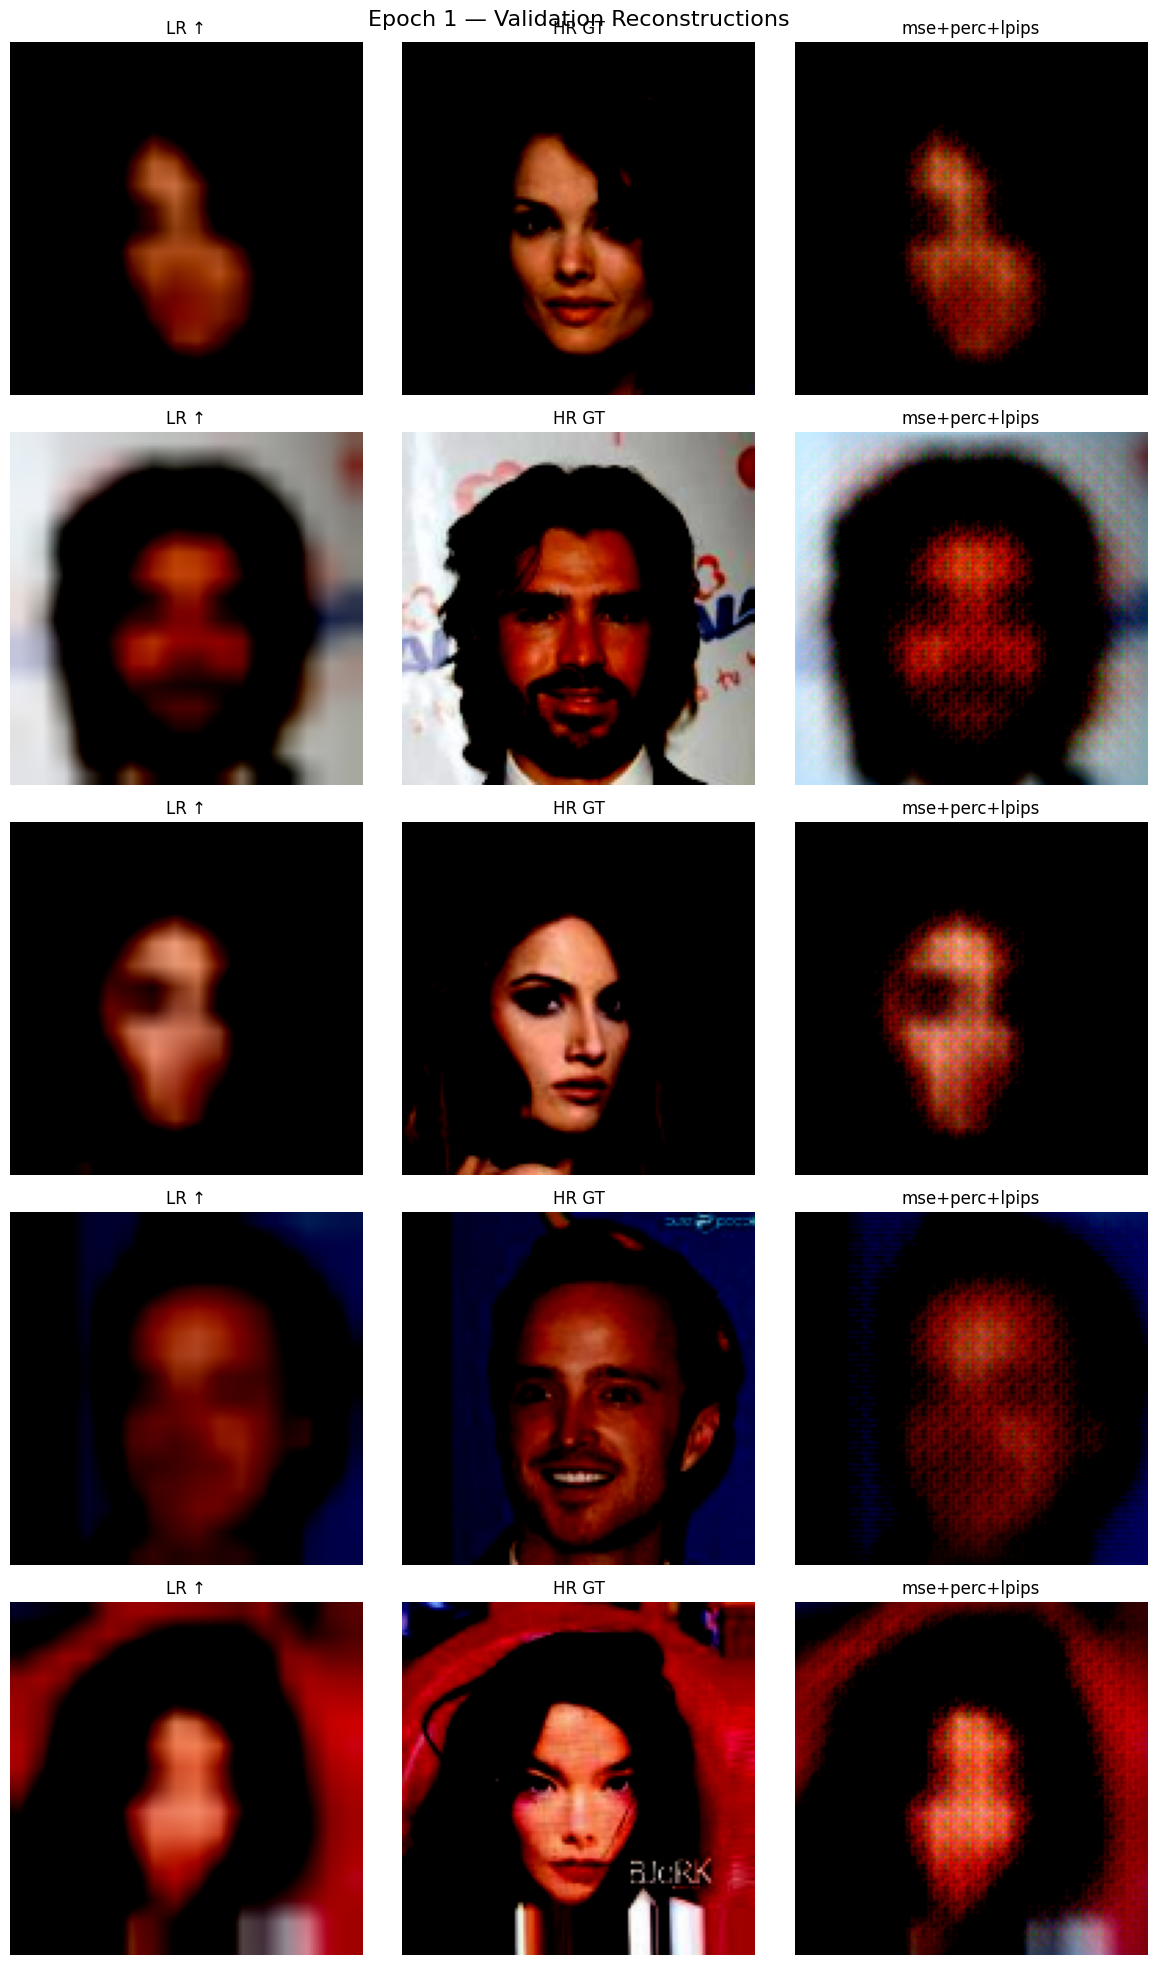


=== Epoch 2/200 ===


Training mse+perc+lpips: 100%|██████████| 157/157 [00:57<00:00,  2.72it/s]


| Model          |      pix |   perc |    attn |   lpips_loss |    comb |   PSNR_o |   SSIM_o |   LPIPS_o |   PSNR_f |   SSIM_f |   LPIPS_f |    MSE_f |
|----------------|----------|--------|---------|--------------|---------|----------|----------|-----------|----------|----------|-----------|----------|
| mse+perc+lpips | 0.055472 | 20.455 | 0.01433 |      0.36092 | 0.62095 |    12.94 |   0.1917 |    0.3626 |    17.08 |   0.7443 |    0.1579 | 0.020835 |


Evaluating mse+perc+lpips: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]



| Model          |      pix |   perc |     attn |   lpips_loss |    comb |   PSNR_o |   SSIM_o |   LPIPS_o |   PSNR_f |   SSIM_f |   LPIPS_f |    MSE_f |   Focus_improvement |
|----------------|----------|--------|----------|--------------|---------|----------|----------|-----------|----------|----------|-----------|----------|---------------------|
| mse+perc+lpips | 0.054853 | 20.369 | 0.012686 |      0.28729 | 0.54584 |    12.91 |   0.2025 |    0.2873 |    17.77 |    0.759 |    0.1361 | 0.017961 |                1.38 |


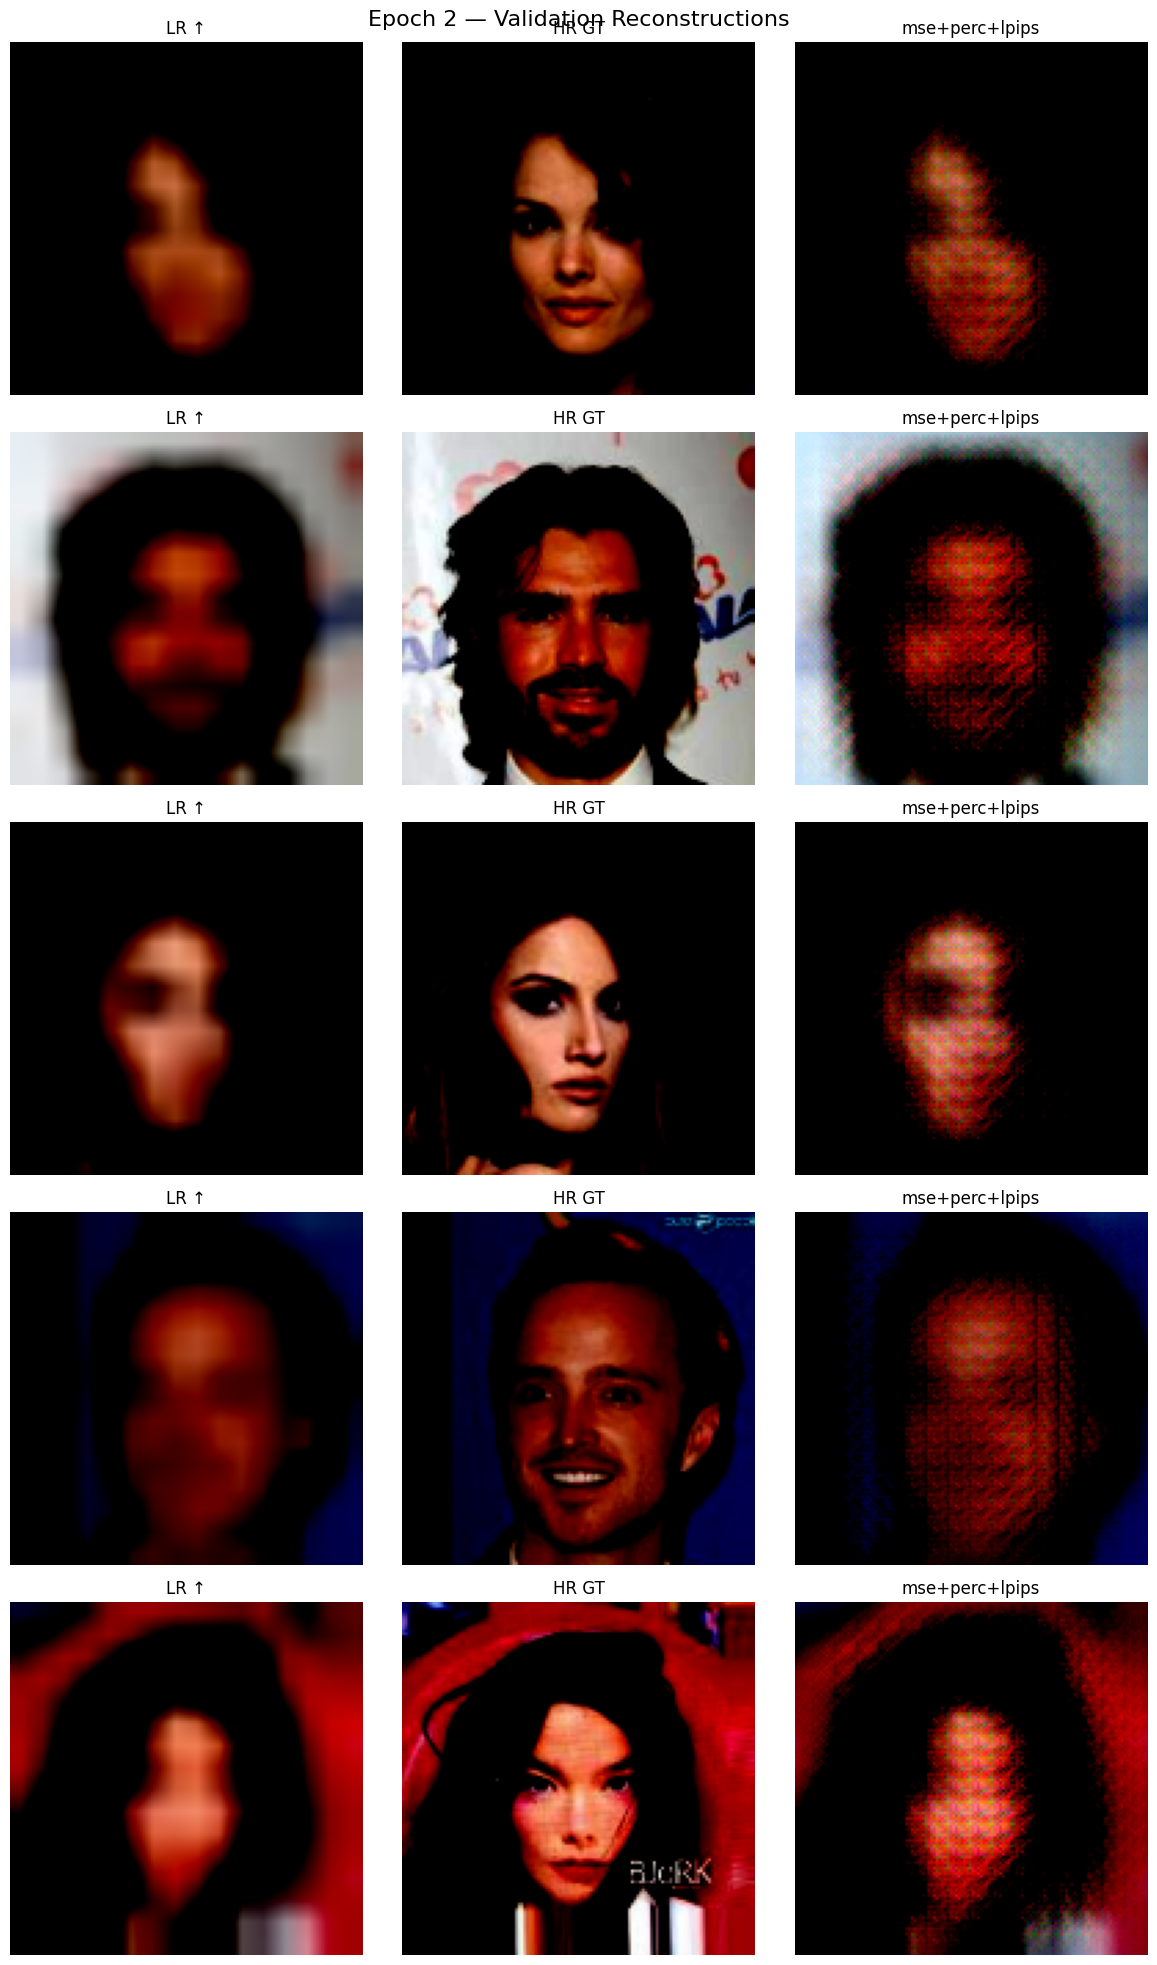


=== Epoch 3/200 ===


Training mse+perc+lpips: 100%|██████████| 157/157 [00:54<00:00,  2.87it/s]


| Model          |      pix |   perc |     attn |   lpips_loss |   comb |   PSNR_o |   SSIM_o |   LPIPS_o |   PSNR_f |   SSIM_f |   LPIPS_f |    MSE_f |
|----------------|----------|--------|----------|--------------|--------|----------|----------|-----------|----------|----------|-----------|----------|
| mse+perc+lpips | 0.055127 | 20.256 | 0.014439 |      0.25572 | 0.5134 |    12.94 |   0.1931 |    0.2568 |    17.04 |   0.7445 |    0.1418 | 0.020894 |


Evaluating mse+perc+lpips: 100%|██████████| 32/32 [00:27<00:00,  1.18it/s]



| Model          |      pix |   perc |     attn |   lpips_loss |   comb |   PSNR_o |   SSIM_o |   LPIPS_o |   PSNR_f |   SSIM_f |   LPIPS_f |    MSE_f |   Focus_improvement |
|----------------|----------|--------|----------|--------------|--------|----------|----------|-----------|----------|----------|-----------|----------|---------------------|
| mse+perc+lpips | 0.054122 | 19.873 | 0.012603 |      0.23924 | 0.4921 |    12.97 |    0.194 |    0.2392 |    17.82 |   0.7604 |    0.1246 | 0.017728 |                1.37 |


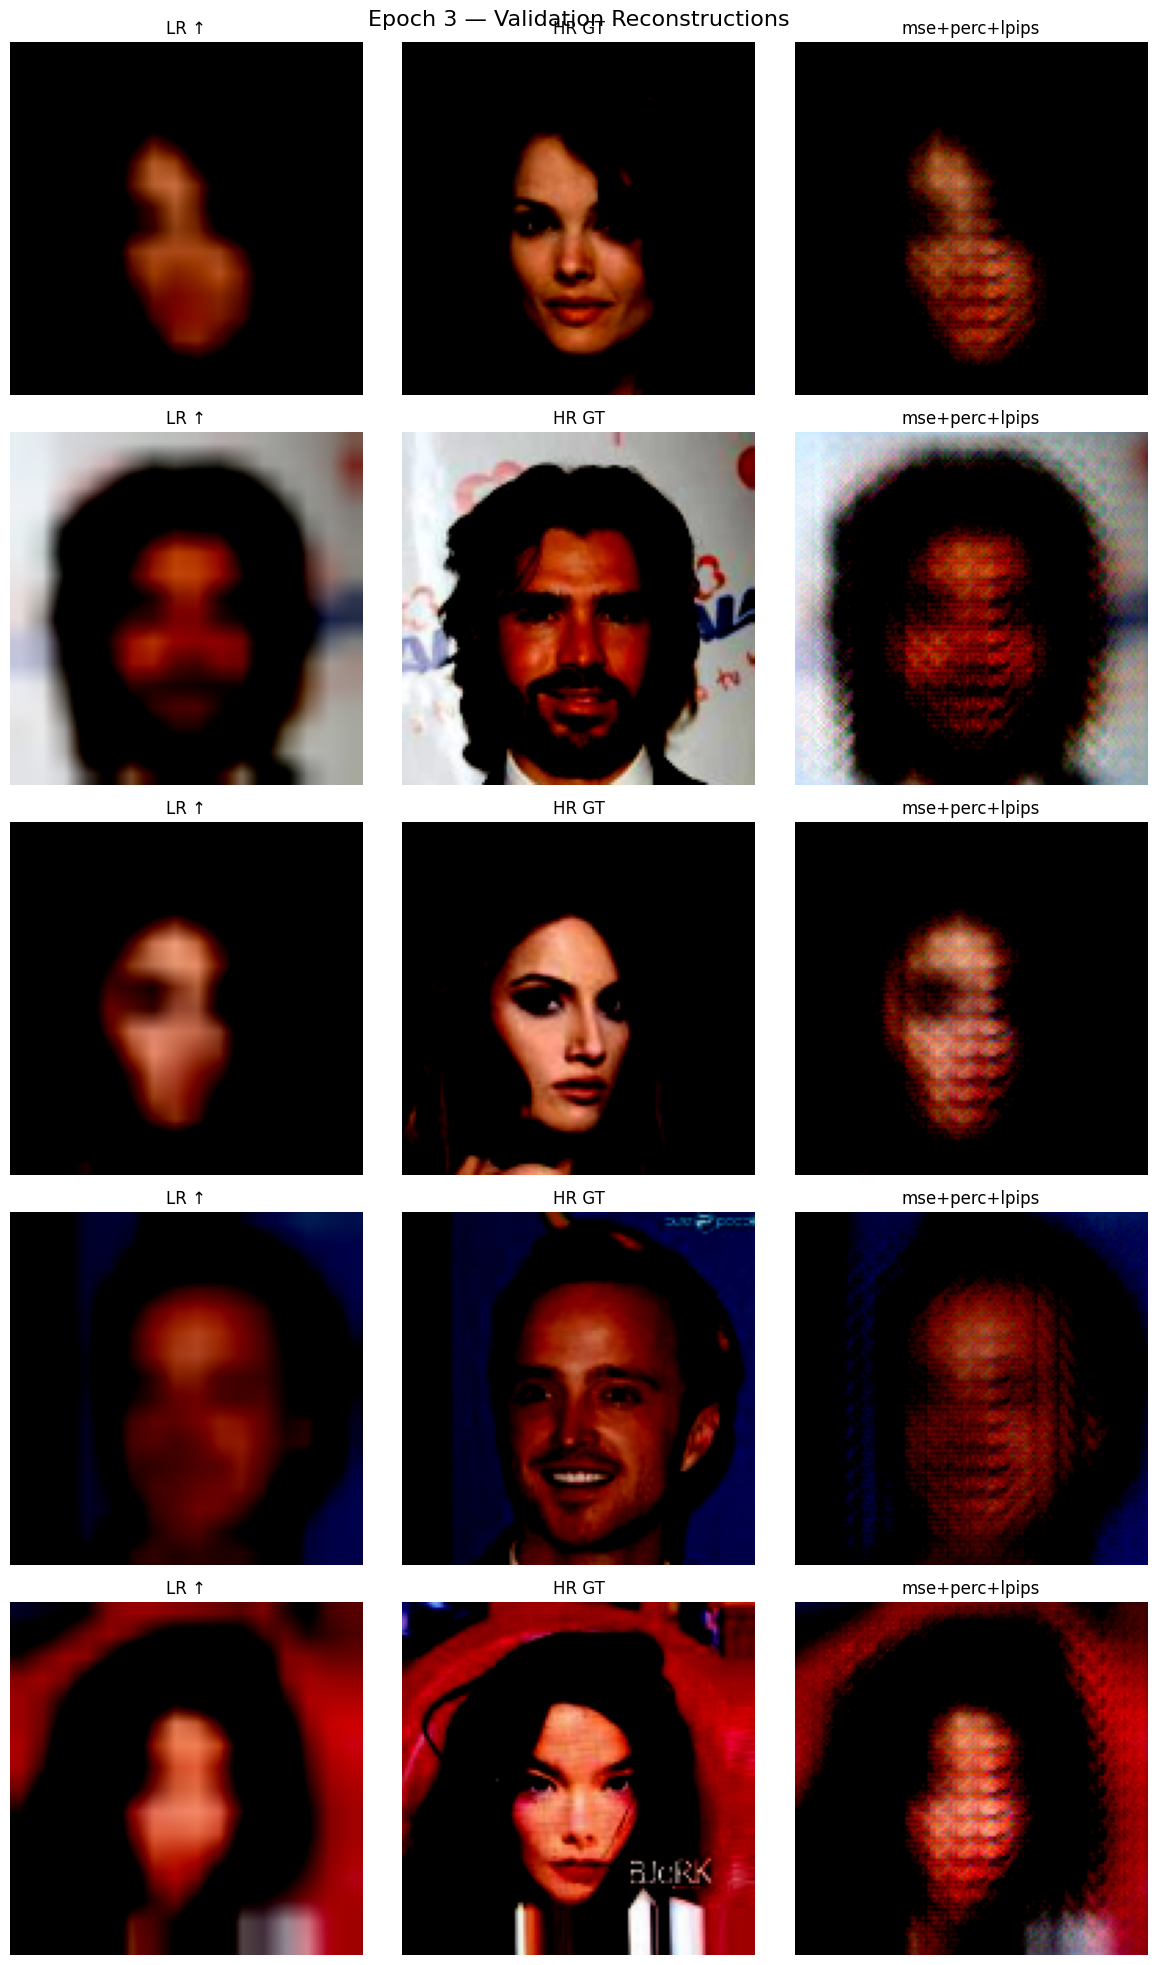


=== Epoch 4/200 ===


Training mse+perc+lpips:  41%|████▏     | 65/157 [00:23<00:23,  3.96it/s]

In [ ]:
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tabulate import tabulate
import torch.nn.functional as F
import os

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
np.random.seed(42)

data_path  = path
heat_h5    = './heatmaps.h5'
batch_size = 64
num_epochs = 200

NUM_SAMPLES = 1000
with h5py.File('heatmaps.h5', 'r') as f:
    heatmaps = f['heatmaps']
    NUM_SAMPLES = heatmaps.shape[0]
    print("Number of heatmaps:", NUM_SAMPLES)

# ——— Data loader & fixed sample ——————————————————————————————————————
full_ds  = CelebDataSet(data_path, 'train', heatmap_h5=heat_h5)
small_ds = Subset(full_ds, range(NUM_SAMPLES))
loader   = DataLoader(small_ds, batch_size=batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_ds = CelebDataSet(data_path, 'val', heatmap_h5=heat_h5)
small_val_ds = Subset(val_ds, range(int(0.2 * NUM_SAMPLES)))
val_loader = DataLoader(small_val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

print("Train samples: ", len(loader.dataset))
print("Val samples:   ", len(val_loader.dataset))

# grab one batch so we have a fixed sample for visualization
data_iter    = iter(loader)
_, _, hr_f, lr_f, heat_f = next(data_iter)
lr_vis, hr_vis, heat_vis = [
    t.to(device, non_blocking=True)
    for t in (lr_f[0:1], hr_f[0:1], heat_f[0:1])
]

# ——— Training loop ————————————————————————————————————————————————————
# initialize trainers & empty history
trainers = {cfg['name']: Trainer(cfg) for cfg in configs}
history  = {}  # we'll build this on the fly

for epoch in range(1, num_epochs+1):
    print(f"\n=== Epoch {epoch}/{num_epochs} ===")

    # 1) Train each model and gather metrics
    epoch_metrics = {}
    for cfg in configs:
        name    = cfg['name']
        metrics = trainers[name].train_epoch(loader)
        epoch_metrics[name] = metrics

        # record history (creates list if needed)
        hist = history.setdefault(name, {})
        for k, v in metrics.items():
            hist.setdefault(k, []).append(v)

    # 2) Print all metrics in a table
    headers = [
      "Model", "pix", "perc", "attn", "lpips_loss", "comb",
      "PSNR_o","SSIM_o","LPIPS_o",
      "PSNR_f","SSIM_f","LPIPS_f","MSE_f"
    ]
    table = []
    for cfg in configs:
        name = cfg['name']
        m    = epoch_metrics[name]
        table.append([
            name,
            f"{m['loss_pixel']:.4e}",
            f"{m['loss_perc']:.4e}"    if cfg['use_perc'] else "-",
            f"{m['loss_attn']:.4e}"    if cfg['use_attn'] else "-",
            f"{m['loss_lpips']:.4e}"   if cfg.get('use_lpips',False) else "-",
            f"{m['loss_combined']:.4e}",
            f"{m['psnr_overall']:.2f}",
            f"{m['ssim_overall']:.4f}",
            f"{m['lpips_overall']:.4f}",
            f"{m['psnr_focused']:.2f}",
            f"{m['ssim_focused']:.4f}",
            f"{m['lpips_focused']:.4f}",
            f"{m['mse_focused']:.4e}"
        ])
    print(tabulate(table, headers=headers, tablefmt="github"))

    # ——— VALIDATION METRICS ——————————————————————————————————————————————
    val_metrics = {}
    for cfg in configs:
        name = cfg['name']
        val_metrics[name] = trainers[name].evaluate(val_loader)
        # record val history
        hist = history[name]
        for k, v in val_metrics[name].items():
            hist.setdefault('val_' + k, []).append(v)

    headers = [
      "Model", "pix", "perc", "attn", "lpips_loss", "comb",
      "PSNR_o","SSIM_o","LPIPS_o",
      "PSNR_f","SSIM_f","LPIPS_f","MSE_f","Focus_improvement"
    ]
    table = []
    for cfg in configs:
        name = cfg['name']
        m    = val_metrics[name]
        table.append([
            name,
            f"{m['loss_pixel']:.4e}",
            f"{m['loss_perc']:.4e}"    if cfg['use_perc'] else "-",
            f"{m['loss_attn']:.4e}"    if cfg['use_attn'] else "-",
            f"{m['loss_lpips']:.4e}"   if cfg.get('use_lpips',False) else "-",
            f"{m['loss_combined']:.4e}",
            f"{m['psnr_overall']:.2f}",
            f"{m['ssim_overall']:.4f}",
            f"{m['lpips_overall']:.4f}",
            f"{m['psnr_focused']:.2f}",
            f"{m['ssim_focused']:.4f}",
            f"{m['lpips_focused']:.4f}",
            f"{m['mse_focused']:.4e}",
            f"{m['focus_improvement']:.2f}"
        ])
    print("\n")
    print(tabulate(table, headers=headers, tablefmt="github"))

    # ——— VALIDATION VISUALIZATION ——————————————————————————————————————————
    # grab first batch from val_loader
    val_iter = iter(val_loader)
    _, _, hr_val_b, lr_val_b, heat_val_b = next(val_iter)
    lr_val = lr_val_b[:5].to(device)
    hr_val = hr_val_b[:5].cpu()

    lr_up_val = F.interpolate(lr_val, size=(128,128), mode='bilinear', align_corners=False).cpu()

    # get reconstructions on val
    recon_val = {cfg['name']: [] for cfg in configs}
    with torch.no_grad():
        for cfg in configs:
            name = cfg['name']
            G = trainers[name].G.eval()
            sr = G(lr_val)
            recon_val[name] = sr.cpu()

    # plot same as before but for val
    fig, axes = plt.subplots(5, 2 + len(configs), figsize=(4*(2+len(configs)), 20))
    for i in range(5):
        row = axes[i]
        # LR upsampled
        row[0].imshow(lr_up_val[i].permute(1,2,0).clamp(0,1))
        row[0].set_title("LR ↑")
        row[0].axis('off')
        # HR GT
        row[1].imshow(hr_val[i].permute(1,2,0).clamp(0,1))
        row[1].set_title("HR GT")
        row[1].axis('off')
        # SR outputs
        for j, cfg in enumerate(configs, start=2):
            nm = cfg['name']
            row[j].imshow(recon_val[nm][i].permute(1,2,0).clamp(0,1))
            row[j].set_title(nm)
            row[j].axis('off')
    plt.suptitle(f"Epoch {epoch} — Validation Reconstructions", fontsize=16)
    plt.tight_layout()
    plt.show()

    # 4) Save checkpoints every 10 epochs
    if epoch % 10 == 0:
        for cfg in configs:
            name   = cfg['name']
            folder = f"./{name}"
            os.makedirs(folder, exist_ok=True)
            path   = os.path.join(folder, f"{name}_epoch{epoch:03d}.pth")
            torch.save(trainers[name].G.state_dict(), path)


## 📊 Interpretazione delle metriche di training

Questa tabella riporta diverse metriche calcolate per ogni modello durante il training:

| Colonna       | Significato |
|---------------|-------------|
| **Model**     | Nome del modello (configurazione usata) |
| **pix**       | Pixel-wise loss (MSE): differenza media pixel a pixel rispetto al ground truth |
| **perc**      | Perceptual loss (VGG): distanza tra le immagini nello spazio delle feature |
| **attn**      | Attention loss: penalizza gli errori nelle regioni salienti definite dalla heatmap |
| **comb**      | Loss totale: somma pesata di tutte le componenti di loss (`pix + w_perc * perc + w_attn * attn`) |
| **PSNR_o**    | PSNR globale: misura la fedeltà dell'immagine generata rispetto al ground truth su tutta l'immagine |
| **SSIM_o**    | SSIM globale: misura la somiglianza strutturale tra output e ground truth |
| **PSNR_f**    | PSNR focalizzato: PSNR calcolato **solo nelle regioni salienti** (top 30% della heatmap) |
| **SSIM_f**    | SSIM focalizzato: SSIM calcolato **solo nelle regioni salienti** |
| **MSE_f**     | MSE focalizzato: errore quadratico medio **solo nelle regioni salienti** |

### ℹ️ Note utili:
- Se un modello **non usa heatmap**, le metriche focalizzate (`PSNR_f`, `SSIM_f`, `MSE_f`) saranno pari a 0.
- Se `PSNR_f` è **molto più alto di `PSNR_o`**, significa che l'attenzione sta aiutando il modello a ricostruire meglio le **zone più importanti** (es. occhi, bocca).
- La `perceptual loss` può migliorare il realismo visivo, ma spesso **abbassa** il PSNR/MSE perché non forza una corrispondenza pixel a pixel.
- `comb` ti dà un'idea di quanto “pesa” ogni loss nel training: un valore alto può indicare un bilanciamento non ottimale.

In [ ]:
# 1) delete big objects
del trainers, history

# 2) force Python GC
import gc
gc.collect()

# 3) release PyTorch cache
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# 4) (for good measure) synchronize
torch.cuda.synchronize()
